# Exploring Unsupervised Learning Techniques

Here we will explore Unsupervised Learning, a subfield of machine learning where the goal is to model the underlying structure or distribution in the data in order to learn more about it. Unlike supervised learning, unsupervised learning does not involve labeled outcomes, making it well-suited for exploratory data analysis, clustering, dimensionality reduction, and anomaly detection, among other applications.

We will look at:
* Clustering Algorithms: Understand and implement popular clustering algorithms like k-means, hierarchical clustering, and DBSCAN.
* Dimensionality Reduction: Delve into techniques such as Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE).

Let's load our libraries and data.

In [48]:
# first we will check if you have yellowbrick and if not install
import subprocess
import sys

# Function to check if a package is installed and install it if necessary
def check_and_install(package_name):
    try:
        # Try to import the package
        __import__(package_name)
        print(f"{package_name} is already installed.")
    except ImportError:
        # If not installed, install the package
        print(f"{package_name} is not installed. Installing now...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"{package_name} has been successfully installed.")

# Check and install 'yellowbrick'
check_and_install("yellowbrick")


yellowbrick is already installed.


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from mpl_toolkits.mplot3d import Axes3D


In [50]:
data = pd.read_csv('9_marketing_campaign_cleaned.csv')

In [51]:
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2216


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,971,64,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,125,67,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,472,56,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,65,37,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,321,40,422,Partner,1,3,1


In [52]:
# Check for NA's with isna and sum
data.isna().sum()

Education              0
Income                 0
Kidhome                0
Teenhome               0
Recency                0
Wines                  0
Fruits                 0
Meat                   0
Fish                   0
Sweets                 0
Gold                   0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
Customer_For           0
Age                    0
Spent                  0
Living_With            0
Children               0
Family_Size            0
Is_Parent              0
dtype: int64

For more info about dataset:

https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

Let's have a little look at the data:

<Figure size 800x550 with 0 Axes>

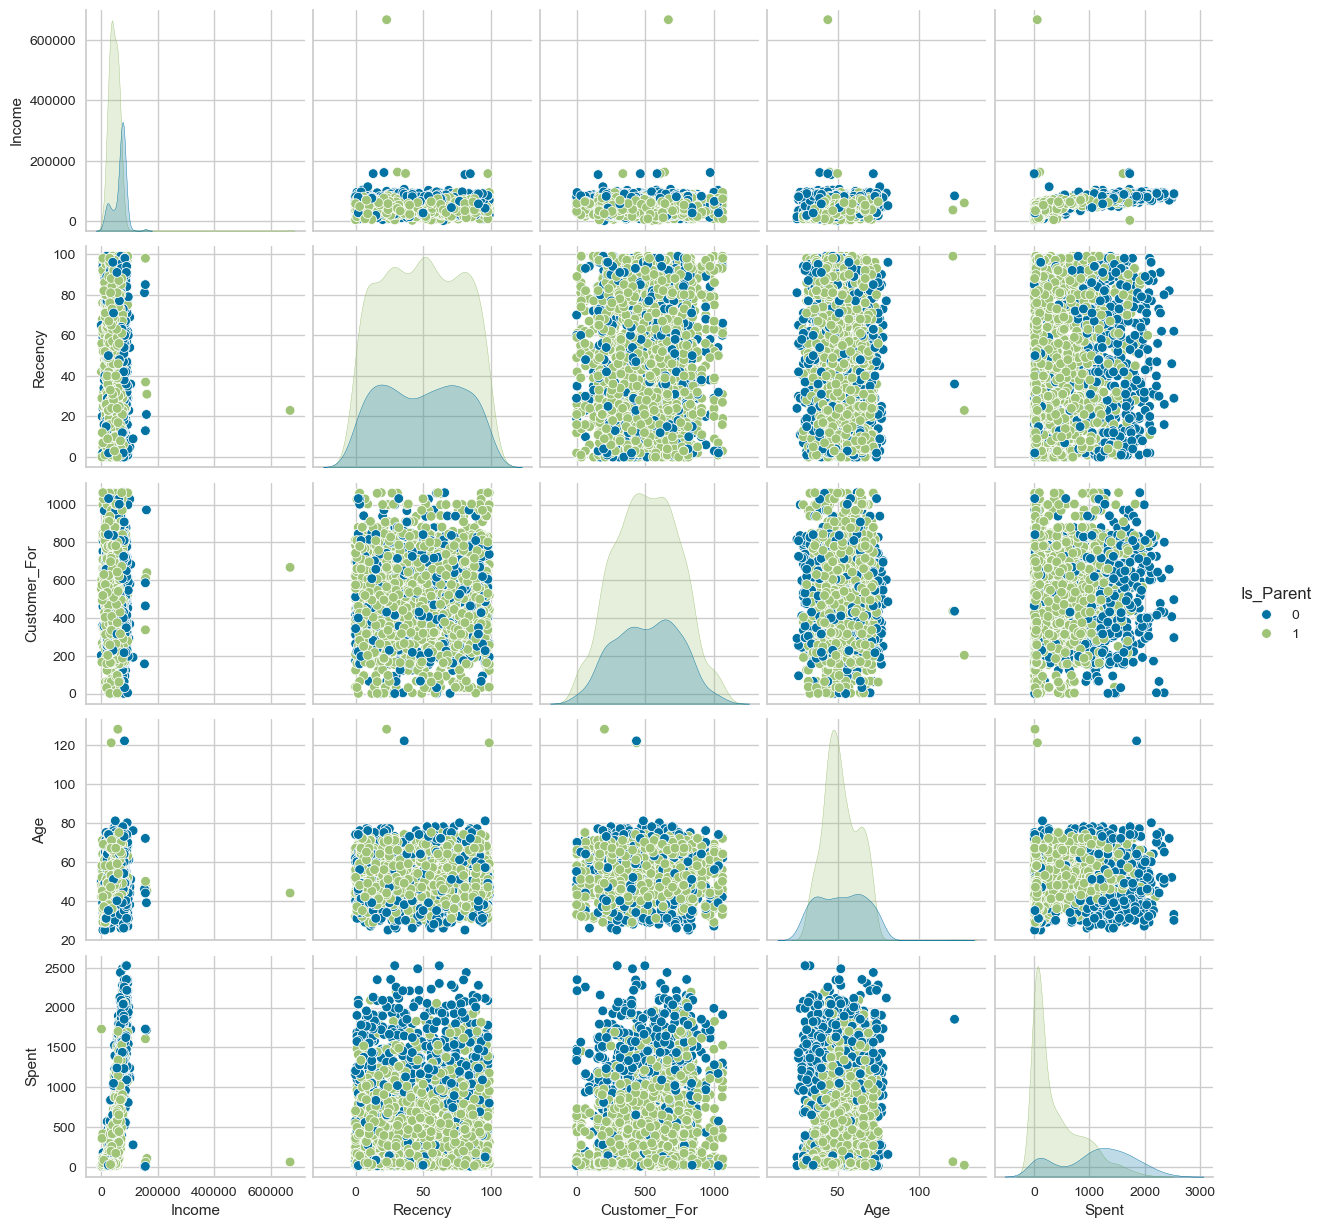

In [53]:
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent")
plt.show()

What about categorical variables? We will need to deal with these. Remember we can find our columns by looking at dtype:

```
select_dtypes(include='int64').columns.tolist()
```

In [54]:
# use .info to check data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   Wines                2216 non-null   int64  
 6   Fruits               2216 non-null   int64  
 7   Meat                 2216 non-null   int64  
 8   Fish                 2216 non-null   int64  
 9   Sweets               2216 non-null   int64  
 10  Gold                 2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   i

In [55]:
# find categorical columns
categorical_columns = data.select_dtypes(include="object").columns.tolist()


In [56]:
# check value counts
data[categorical_columns].value_counts()

Education      Living_With
Graduate       Partner        714
Postgraduate   Partner        546
Graduate       Alone          402
Postgraduate   Alone          300
Undergraduate  Partner        170
               Alone           84
Name: count, dtype: int64

Let's onehot encode for now, even though this isn't perfect for clustering.

In [57]:
encoder = OneHotEncoder(sparse_output=False, drop=None)

encoded = encoder.fit_transform(data[categorical_columns])

# Create a DataFrame for the encoded data
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_columns), index=data.index)

# Drop the original categorical columns and concatenate the new one-hot encoded columns
data = data.drop(columns=categorical_columns).join(encoded_df)

All features are now numerical and we can run them in k means. Think about whether this makes sense in practice.

However, remember scaling is important for clustering. We will apply StandardScalar which we have seen before.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


In [58]:
scaler = StandardScaler()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data),columns= data.columns )


In [59]:
# check our results:
scaled_data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,Age,Spent,Children,Family_Size,Is_Parent,Education_Graduate,Education_Postgraduate,Education_Undergraduate,Living_With_Alone,Living_With_Partner
count,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,...,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03
mean,5.210433e-17,-1.122247e-16,4.168346e-17,-2.404815e-18,-3.366741e-17,-7.214446e-18,-5.771557e-17,-2.164334e-17,-1.122247e-17,-1.442889e-17,...,8.196412e-17,1.442889e-17,-2.565136e-17,1.603210e-17,-7.695409e-17,-1.122247e-16,-4.809630e-17,-3.687383e-17,1.362729e-16,1.202408e-16
std,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,...,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00
min,-2.007250e+00,-8.230393e-01,-9.289722e-01,-1.693488e+00,-9.046404e-01,-6.624630e-01,-7.447440e-01,-6.875744e-01,-6.582331e-01,-8.486891e-01,...,-2.268209e+00,-9.988568e-01,-1.264803e+00,-1.758673e+00,-1.581389e+00,-1.007246e+00,-7.858233e-01,-3.598051e-01,-7.413841e-01,-1.348829e+00
25%,-6.732620e-01,-8.230393e-01,-9.289722e-01,-8.642385e-01,-8.334770e-01,-6.121927e-01,-6.733896e-01,-6.327696e-01,-6.338802e-01,-6.749564e-01,...,-6.826092e-01,-8.926794e-01,-1.264803e+00,-6.543319e-01,-1.581389e+00,-1.007246e+00,-7.858233e-01,-3.598051e-01,-7.413841e-01,-1.348829e+00
50%,-3.439972e-02,-8.230393e-01,-9.289722e-01,-4.365786e-04,-3.872229e-01,-4.613818e-01,-4.414876e-01,-4.683552e-01,-4.634095e-01,-3.757501e-01,...,-9.844093e-02,-3.493494e-01,7.050118e-02,4.500089e-01,6.323556e-01,9.928057e-01,-7.858233e-01,-3.598051e-01,-7.413841e-01,7.413841e-01
75%,6.466600e-01,1.039938e+00,9.090657e-01,8.633654e-01,5.927571e-01,1.669967e-01,2.910105e-01,2.258390e-01,1.454144e-01,2.323143e-01,...,8.195377e-01,7.315041e-01,7.050118e-02,4.500089e-01,6.323556e-01,9.928057e-01,1.272551e+00,-3.598051e-01,1.348829e+00,7.413841e-01
max,2.441328e+01,2.902916e+00,2.747104e+00,1.727167e+00,3.522319e+00,4.339430e+00,6.948158e+00,4.043907e+00,5.722241e+00,5.347777e+00,...,6.327410e+00,3.181881e+00,2.741110e+00,2.658691e+00,6.323556e-01,9.928057e-01,1.272551e+00,2.779282e+00,1.348829e+00,7.413841e-01


Outliers can be a big problem! Let's remove by removing any values greater than 3 standard deviaitons from the mean.

Filter thedata appropriately and drop where we find NA.

In [60]:
scaled_data = scaled_data[(scaled_data > -3) & (scaled_data < 3)].dropna()

In [61]:
scaled_data.describe()


,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,Age,Spent,Children,Family_Size,Is_Parent,Education_Graduate,Education_Postgraduate,Education_Undergraduate,Living_With_Alone,Living_With_Partner
count,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,...,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000
mean,-0.232587,0.161711,0.070621,0.012669,-0.291136,-0.195706,-0.254890,-0.214155,-0.208106,-0.197504,...,-0.038317,-0.321231,0.167213,0.147613,0.193545,-0.013574,0.004048,0.015130,-0.017645,0.017645
std,0.725251,1.027198,0.996631,1.000823,0.763510,0.728401,0.702648,0.719875,0.700394,0.783706,...,0.951262,0.767598,0.960417,0.956886,0.882811,1.000324,1.001295,1.018350,0.994786,0.994786
min,-1.777985,-0.823039,-0.928972,-1.693488,-0.904640,-0.662463,-0.744744,-0.687574,-0.658233,-0.848689,...,-2.268209,-0.993880,-1.264803,-1.758673,-1.581389,-1.007246,-0.785823,-0.359805,-0.741384,-1.348829
25%,-0.802725,-0.823039,-0.928972,-0.864239,-0.857198,-0.637328,-0.691228,-0.651038,-0.633880,-0.732867,...,-0.682609,-0.915906,0.070501,-0.654332,0.632356,-1.007246,-0.785823,-0.359805,-0.741384,-1.348829
50%,-0.288399,1.039938,0.909066,0.034115,-0.664464,-0.511652,-0.570818,-0.541428,-0.512115,-0.520527,...,-0.098441,-0.693597,0.070501,0.450009,0.632356,-1.007246,-0.785823,-0.359805,-0.741384,0.741384
75%,0.354745,1.039938,0.909066,0.863365,0.063479,-0.134625,-0.147150,-0.139526,-0.122468,-0.018633,...,0.736085,0.124716,0.070501,0.450009,0.632356,0.992806,1.272551,-0.359805,1.348829,0.741384
max,1.484808,2.902916,2.747104,1.727167,2.914464,2.906727,2.992446,2.947811,2.994710,2.992734,...,2.405137,2.519931,2.741110,2.658691,0.632356,0.992806,1.272551,2.779282,1.348829,0.741384


### K Means

Great our data is all ready, let's start to look at our clustering approaches. We follow a very familiar approach, only we don't need to split our data into training and test splits, we just:

* Model Initialization - Initialize the `KMeans` model with desired parameters. The number of clusters `n_clusters` (k) is a required input.
* Model Fitting - Fit the model to your data using `.fit(X)`.

https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html

In [62]:
km3 = KMeans(n_clusters = 3)

In [63]:
km3.fit(scaled_data)

c:\Users\nunor\.conda\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",3
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",None
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


We can then look at the clusters designated by checking the labels `.labels_` and the centroids of the clusters `.cluster_centers_`.

In [64]:
labels = km3.labels_
labels

array([1, 0, 1, ..., 2, 1, 0], shape=(1574,), dtype=int32)

In [65]:
centroids = km3.cluster_centers_
centroids

array([[-0.27969919,  0.41569452,  0.98284383, -0.01159214, -0.53345412,
        -0.50195776, -0.55753977, -0.52666699, -0.5116904 , -0.44139254,
         0.29091716, -0.32662529, -0.57108239, -0.44459971,  0.22684926,
        -0.28177297, -0.28270484, -0.28083892, -0.26166148, -0.11714818,
        -0.09781206, -0.26424478, -0.14987547,  0.36557303, -0.65963441,
         1.01197239,  0.89135984,  0.63235564, -0.09622796,  0.17690661,
        -0.11875829, -0.10301199,  0.10301199],
       [ 0.55931678, -0.71228906,  0.03102209,  0.01900355,  0.58062581,
         0.51307184,  0.53019613,  0.50451734,  0.47927222,  0.45084293,
        -0.06998263,  0.59024634,  0.66460483,  0.93595285, -0.54222655,
        -0.28177297, -0.28270484, -0.28083892, -0.26166148, -0.11714818,
        -0.09781206, -0.14721753,  0.1583293 ,  0.20790631,  0.67318115,
        -0.48800195, -0.44096672, -0.34526389,  0.03312035,  0.05762933,
        -0.13986908,  0.07073675, -0.07073675],
       [-0.88540042,  0.6638

Its usuall easier to understand if we plot our centeroids.

<Figure size 1000x600 with 0 Axes>

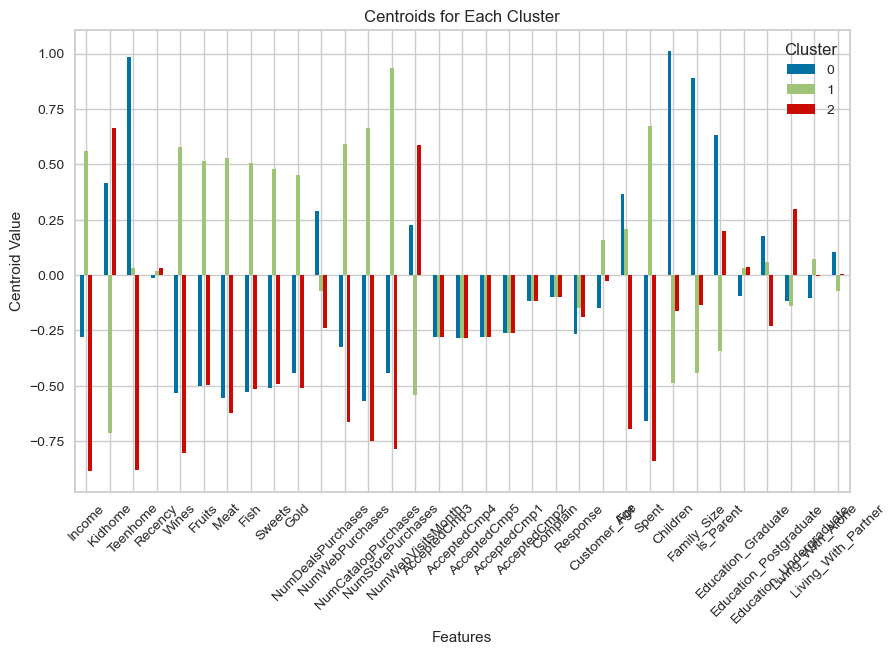

In [66]:
centroid_df = pd.DataFrame(centroids, columns=scaled_data.columns)

# Plot centroids
plt.figure(figsize=(10, 6))
centroid_df.T.plot(kind='bar', figsize=(10, 6), legend=True)
plt.title('Centroids for Each Cluster')
plt.ylabel('Centroid Value')
plt.xlabel('Features')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()

Let's try to visualise, here is some example code where we set the hue of the data based on our finding of the labels:

```
pl = sns.scatterplot(data = scaled_data,x="Spent", y="Income",hue=labels)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()
```




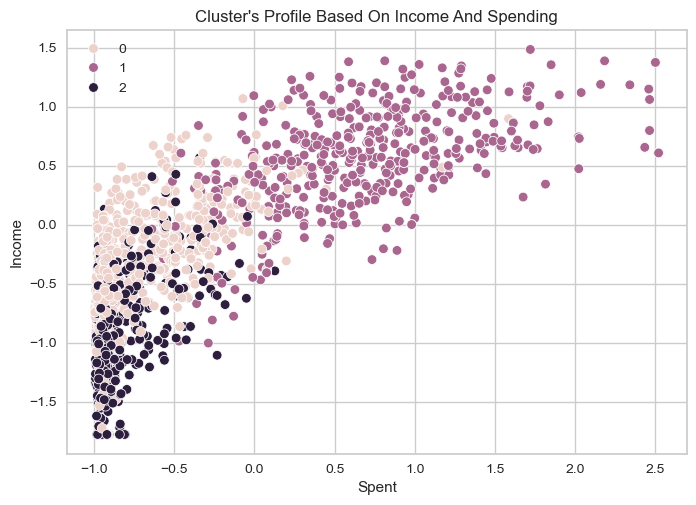

In [67]:
pl = sns.scatterplot(data = scaled_data,x="Spent", y="Income",hue=labels)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Here we provide a function to look at 3 features at a time.

In [68]:
def plot_3d_clusters(data, labels, feature_names, colors=None, markers=None):
    """
    Plots a 3D scatter plot for clustering data with up to 10 different clusters.
    """
    if len(feature_names) != 3:
        raise ValueError("Three feature names must be provided for x, y, and z axes.")

    # Default color and marker arrays for up to 10 clusters
    default_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    default_markers = ['o', '^', 's', 'P', '*', 'D', 'x', '+', 'H', '1']

    # Use default colors and markers if none are provided
    if colors is None:
        colors = default_colors
    if markers is None:
        markers = default_markers

    # Check if there are enough colors and markers for the number of clusters
    unique_labels = np.unique(labels)
    if len(unique_labels) > len(colors) or len(unique_labels) > len(markers):
        raise ValueError("Not enough colors or markers for the number of clusters.")

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for label, color, marker in zip(unique_labels, colors, markers):
        idx = (labels == label)
        ax.scatter(data.loc[idx, feature_names[0]], data.loc[idx, feature_names[1]], data.loc[idx, feature_names[2]], label=f'Cluster {label}', c=color, marker=marker)

    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel(feature_names[2])
    ax.legend()
    ax.set_title('3D Cluster Plot with Distinct Colors and Markers')

    plt.show()


See if you can use the function.

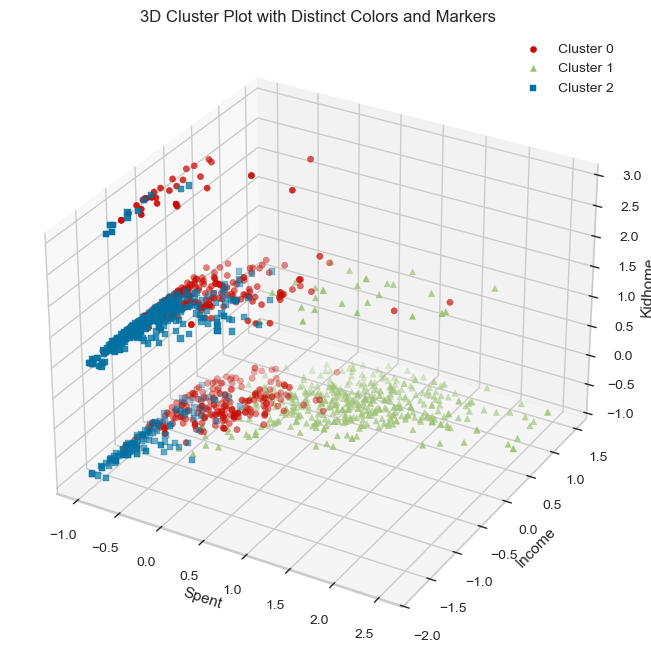

In [69]:
plot_3d_clusters(scaled_data, labels, ["Spent", "Income", "Kidhome"])

#### Choosing k

Ok but what value of k should we use? We can Use an elbow visualiser to help us pick.

https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

We need to specify our classifier and max k `KElbowVisualizer(alg, k=)` then we can use fit and show.



In [70]:
KEV = KElbowVisualizer(KMeans(), k=10)
KEV.fit(scaled_data)
KEV.show()

YellowbrickTypeError: The supplied model is not a clustering estimator; try a classifier or regression score visualizer instead!

Or we can look at silhoute score. We will need a loop to calculate the score at each point in time and add to a list. Try setting the k means init to 'k-means++'.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [ ]:
# List to store the silhouette scores
silhouette_scores = []

# Range of k values to try
k_range = range(2, 11)  # Usually, a minimum of 2 clusters is considered
# Compute silhouette scores for different k values
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)  # Exclude the 'Cluster_Labels' column for fitting
    labels = kmeans.labels_
    score = silhouette_score(scaled_data, labels)
    silhouette_scores.append(score)





c:\Users\nunor\.conda\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\nunor\.conda\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\nunor\.conda\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\nunor\.conda\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a m

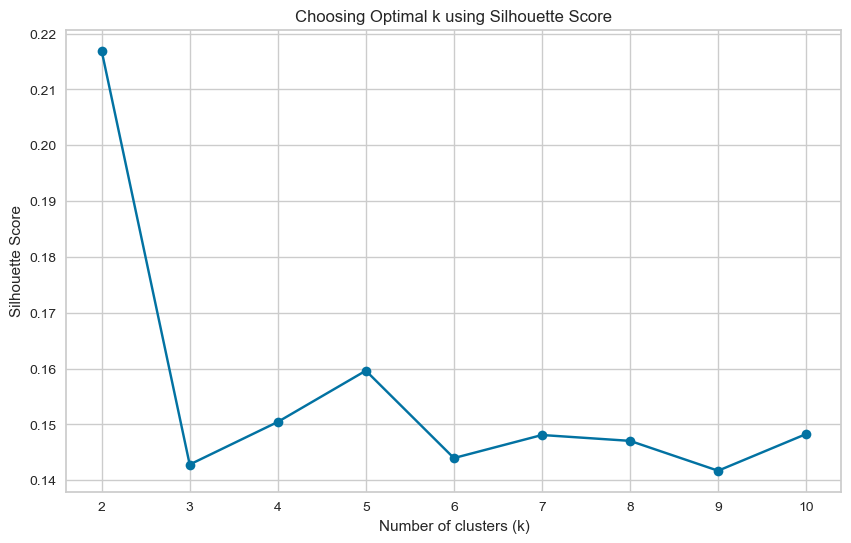

Optimal K: 2 with score 0.21694283111802593


In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Choosing Optimal k using Silhouette Score')
plt.grid(True)
plt.show()

# Find the optimal k (where silhouette score is maximum)
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal K: {optimal_k} with score {max(silhouette_scores)}")

We can also look at the clusters themselves with the slihoute visualiser:

https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

In [71]:
km5 = KMeans(n_clusters=7)
ssv = SilhouetteVisualizer(km5)
ssv.fit(scaled_data)
ssv.show()

YellowbrickTypeError: The supplied model is not a clustering estimator; try a classifier or regression score visualizer instead!

## Hierarchical Methods:
Let's examine how agglomerative and divisive techniques build the dendrogram in hierarchical clustering.

We need to set the linkage type we will use by creating a linkage object, here we use ward.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

```
Z = linkage(hc_data, method='ward')
```

In [ ]:
Z = linkage(scaled_data, method="ward")

In [ ]:
Z

array([[6.10000000e+01, 2.94000000e+02, 0.00000000e+00, 2.00000000e+00],
       [7.53000000e+02, 1.01200000e+03, 0.00000000e+00, 2.00000000e+00],
       [2.03000000e+02, 1.08800000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [3.14200000e+03, 3.14300000e+03, 5.99986569e+01, 9.45000000e+02],
       [3.13500000e+03, 3.14100000e+03, 6.81876369e+01, 6.29000000e+02],
       [3.14400000e+03, 3.14500000e+03, 1.06580118e+02, 1.57400000e+03]])

With our linkage type we can create a dendrogram.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

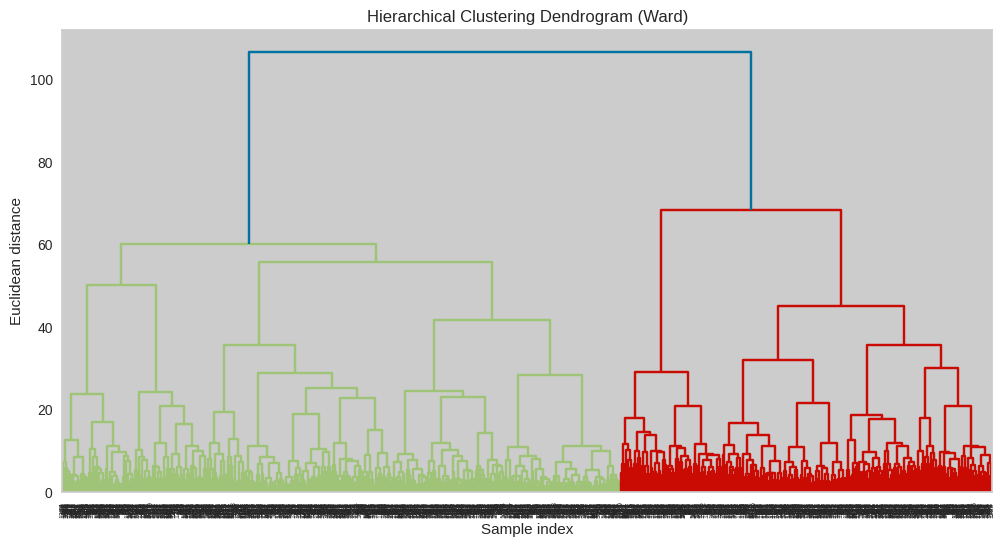

In [ ]:
# Create a dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')
plt.show()

Next we can fit our all an `AgglomerativeClustering` model. We follow the same steps: initialise, fit, predict (on our case just check labels with `.labels_`)

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

To initialise we need to set `n_clusters`, `metric` for which we cna use 'euclidean' and `linkage` for which again we can use'ward'

In [ ]:
ag = AgglomerativeClustering(n_clusters=3)
ag.fit(scaled_data)


AgglomerativeClustering(n_clusters=3)

Let's plot our clusters:

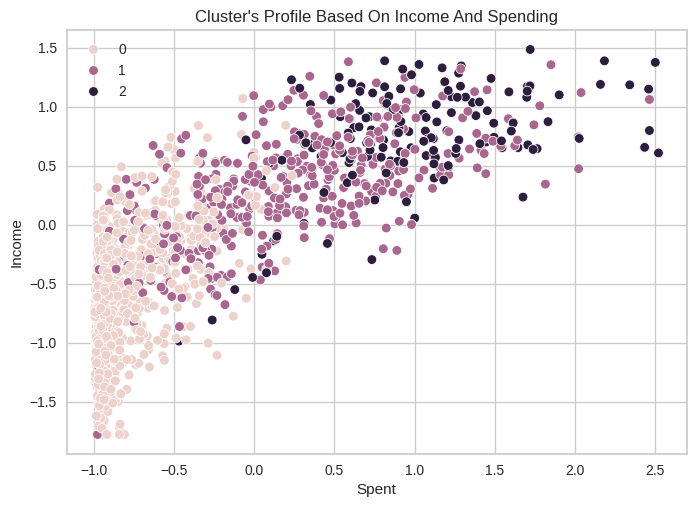

In [ ]:
labels = ag.labels_
pl = sns.scatterplot(data = scaled_data,x="Spent", y="Income",hue=labels)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Again we can explore values for k using KElbowVisualiser and Silhoute score:

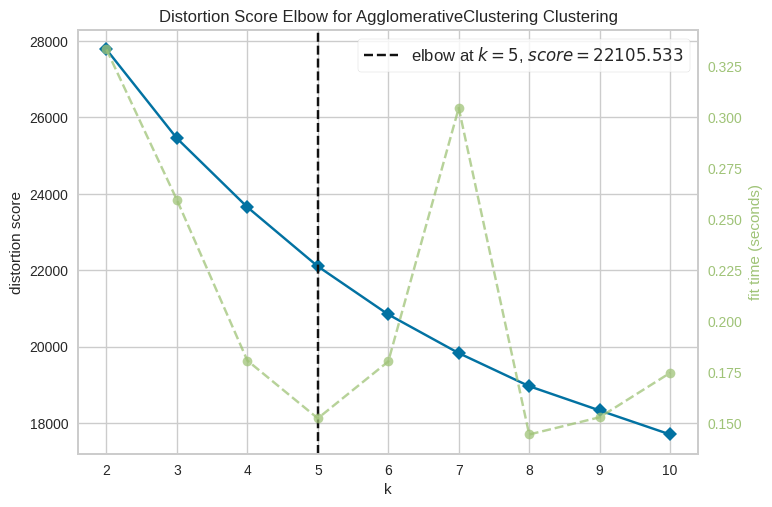

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
KEV_ag = KElbowVisualizer(AgglomerativeClustering(), k=10)
KEV_ag.fit(scaled_data)
KEV_ag.show()

In [ ]:
# List to store the silhouette scores
silhouette_scores = []

# Range of k values to try
k_range = range(2, 11)  # Usually, a minimum of 2 clusters is considered

# Compute silhouette scores for different k values
for k in k_range:
    ag = AgglomerativeClustering(n_clusters=k)
    ag.fit(scaled_data)
    labels = ag.labels_
    score = silhouette_score(scaled_data, labels)
    silhouette_scores.append(score)


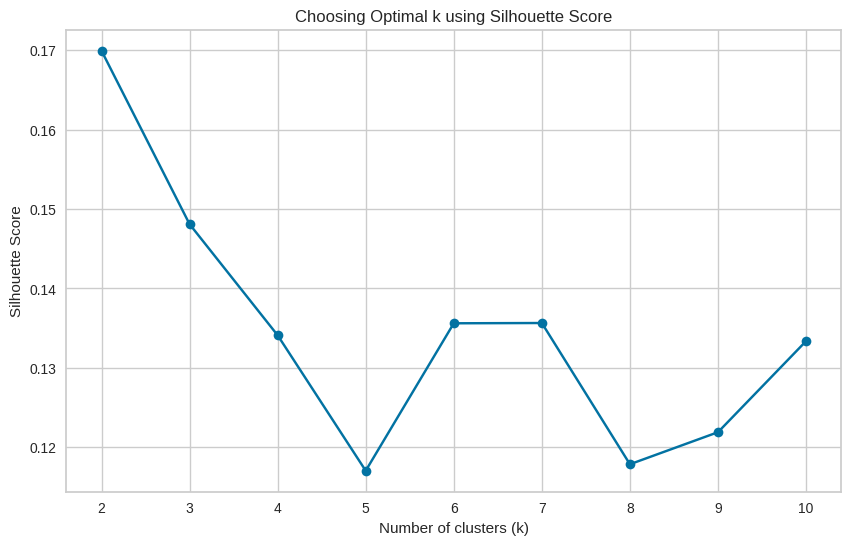

(2, 0.16995149961151934)

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Choosing Optimal k using Silhouette Score')
plt.grid(True)
plt.show()

# Find the optimal k (where silhouette score is maximum)
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
optimal_k, max(silhouette_scores)

### DBSCAN
Finally, let's take a look at DBSCAN.

We initialise `DBSCAN` with `eps` and `min_samples`

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [ ]:
dbs = DBSCAN(eps=3.4, min_samples=20)
dbs.fit(scaled_data)

DBSCAN(eps=3.4, min_samples=20)

DBSCAN will identify the number of clusters iteself, let's take a look at what it found:

```
u, c = np.unique(X, return_counts=True)

cluster_summary_df = pd.DataFrame({
    'Cluster_ID': u,
    'Number_of_Points': c
})

```

In [ ]:
dbscan_labels = dbs.labels_

# Count the number of unique clusters and noise points
unique_clusters, counts = np.unique(dbscan_labels, return_counts=True)

# Number of unique clusters (excluding noise)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)


# Create a DataFrame to display the cluster IDs and their corresponding counts
cluster_summary_df = pd.DataFrame({
    'Cluster_ID': unique_clusters,
    'Number_of_Points': counts
})

# Highlight the noise points (-1)
cluster_summary_df['Type'] = ['Noise' if id == -1 else 'Cluster' for id in unique_clusters]

cluster_summary_df

,Cluster_ID,Number_of_Points,Type
0,-1,285,Noise
1,0,1039,Cluster
2,1,23,Cluster
3,2,95,Cluster
4,3,113,Cluster
5,4,19,Cluster


Let's see our plot again:

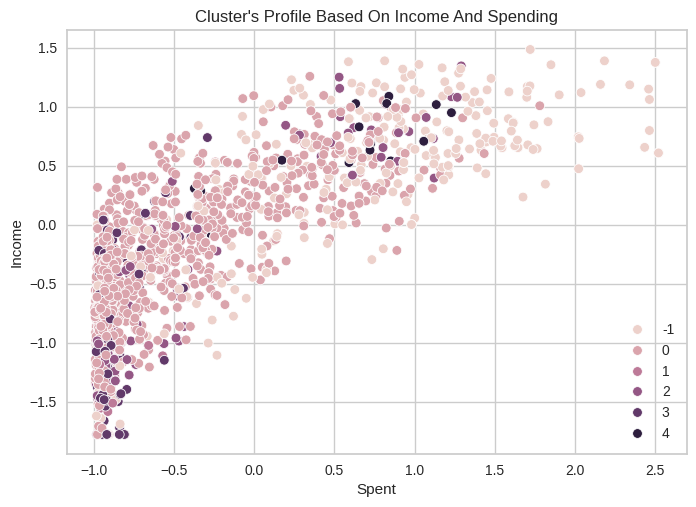

In [ ]:
dbscan_labels = dbs.labels_
pl = sns.scatterplot(data = scaled_data,x=scaled_data["Spent"], y=scaled_data["Income"],hue=dbscan_labels)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Maybe it would be helpful to work with less data, try again with a subset of the features:

In [ ]:
db_data_small = scaled_data[["Spent", "Income", "Age"]].copy()
dbscan_small = DBSCAN(eps=0.15, min_samples=5)
dbscan_labels_small = dbscan_small.fit_predict(db_data_small)


In [ ]:
# Count the number of unique clusters and noise points
unique_clusters, counts = np.unique(dbscan_labels_small, return_counts=True)

# Number of unique clusters (excluding noise)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)


# Create a DataFrame to display the cluster IDs and their corresponding counts
cluster_summary_df = pd.DataFrame({
    'Cluster_ID': unique_clusters,
    'Number_of_Points': counts
})

# Highlight the noise points (-1)
cluster_summary_df['Type'] = ['Noise' if id == -1 else 'Cluster' for id in unique_clusters]

cluster_summary_df


### Exercise

We have seen how to apply different unsupervised techniques to clustering. But we have not produced very useful output and there are a number of decisions that may result in not very effective clustering. Try to imporve the clustering:
* Look at the features, in particular their correlations, and check we are not adding too much importance to one type of feature by including it multiple times.
* Think about the data types of features, have we dealt with these well? What other approaches could we take?
* Think about the difference between centroids and medoids? Which is more useful? can you produce both?

Make use of additional visualisation functionality from yellowbricks:

https://www.scikit-yb.org/en/latest/api/cluster/icdm.html
https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

Try to produce the most useful clustering of the customer data for a sales or marketing team. Understand the difference between the clusters.
* One you have found the "best" clustering give each cluster a name and describe it's proporties.